# Introduction

In this notebook we are analyzing Form 10-K (annual reports) of S&P 500 companies.  
"A Form 10-K is an annual report required by the U.S. Securities and Exchange Commission (SEC), that gives a comprehensive summary of a company's financial performance." - Wikipedia.  
We have gathered the list of S&P 500 companies from <a href="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies">Wikipedi article</a> and the corressponding annual reports were scrape from <a href="https://www.sec.gov/edgar/aboutedgar.htm">SEC EDGAR website</a>. The baseline for the code was taken from <a href="https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html">Ahmed BESBES's article</a>.

In [1]:
# pandas
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from collections import Counter
import re
import numpy as np

# for progress bar
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF

# gensim
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel

from wordcloud import WordCloud

# matplotlib for plotting
from matplotlib import pyplot as plt
%matplotlib inline

# seaborn for plotting
import seaborn as sns
sns.set()
sns.set_palette("Set2", 12)
sns.set(font_scale=1.5)

# bokeh for plotting
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file
from bokeh.models.sources import ColumnDataSource

# for plotting
import pyLDAvis
import pyLDAvis.gensim

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

## Data

In [7]:
df = pd.read_csv("private/sandp500/sandp500.csv")
print(df.shape)
df.head()

(504, 12)


,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Location,Date first added[3][4],CIK,Founded,File,Form10K,tokens
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902,MMM/mmm-20171231x10k.htm,10-K1mmm-20171231x10k.htm10-Kmmm_Current_Folio...,['10-k1mmm-20171231x10k.htm10-kmmm_current_fol...
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",3/31/64,1800,1888,ABT/a2234264z10-k.htm,10-K1a2234264z10-k.htm10-K UNITED STATE...,"['10-k1a2234264z10-k.htm10-k', ' ', 'uni..."
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/12,1551152,2013 (1888),ABBV/abbv-20171231x10k.htm,10-K1abbv-20171231x10k.htm10-KDocumentUNITED S...,['10-k1abbv-20171231x10k.htm10-kdocumentunited...
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",5/31/18,815094,1981,ABMD/abmd-10k_20180331.htm,10-K1abmd-10k_20180331.htm10-Kabmd-10k_2018033...,['10-k1abmd-10k_20180331.htm10-kabmd-10k_20180...
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",7/6/11,1467373,1989,ACN/acn831201710k.htm,10-K1acn831201710k.htm10-KDocumentTable of Con...,"['10-k1acn831201710k.htm10-kdocumenttable', 'c..."


Columns except Form10K and tokens were directly taken from the <a href="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies">Wikipedia article.</a> Entries for the column from Form10K were scraped from <a href="https://www.sec.gov/edgar/aboutedgar.htm">SEC EDGAR</a> and the entries for the column tokens represent the same text as entries for the column Form10K but NFKD unicode normalized, lemmatized using <a href="https://spacy.io/">spaCy</a>, tokenized, punctuations and numeric values removed.

## Exploratory Data Analysis

### Companies by GICS Sector

Text(0.5,1,'Number of companies in each GICS sector')

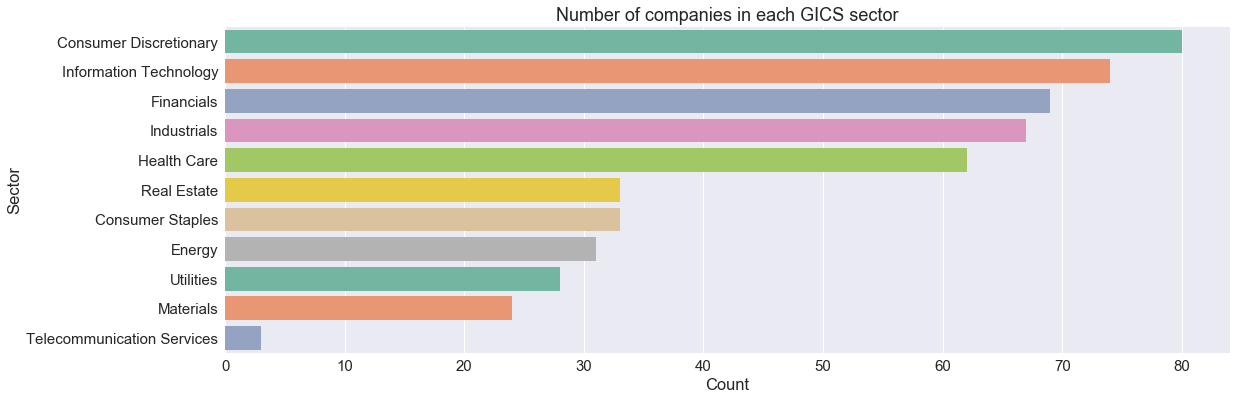

In [8]:
stats = pd.DataFrame(df['GICS Sector'].value_counts().reset_index())
stats.columns = ['Sector', 'Count']

sns.set_palette("Set2", 12)
plt.figure(figsize=(18, 6))
ax = sns.barplot(x='Count', y='Sector', data=stats)
ax.set_title("Number of companies in each GICS sector")

We can see that there are 11 GICS (Global Industry Classification Standard) sectors in S&P 500. The majority of companies are in Consumer Discretionary sector and the minority is Telecommunication Services sector.

Companies in Consumer Discretionary (majority sector) sector are:

In [9]:
print(list(df[df['GICS Sector']=='Consumer Discretionary']['Security'].unique()))

['Advance Auto Parts', 'Amazon.com Inc.', 'Aptiv Plc', 'AutoZone Inc', 'Best Buy Co. Inc.', 'Booking Holdings Inc', 'BorgWarner', 'Carmax Inc', 'Carnival Corp.', 'CBS Corp.', 'Charter Communications', 'Chipotle Mexican Grill', 'Comcast Corp.', 'D. R. Horton', 'Darden Restaurants', 'Discovery Inc. Class A', 'Discovery Inc. Class C', 'Dish Network', 'Dollar General', 'Dollar Tree', 'Expedia Inc.', 'Foot Locker Inc', 'Ford Motor', 'Gap Inc.', 'Garmin Ltd.', 'General Motors', 'Genuine Parts', 'Goodyear Tire & Rubber', 'Hanesbrands Inc', 'Harley-Davidson', 'Hasbro Inc.', 'Hilton Worldwide Holdings Inc', 'Home Depot', 'Interpublic Group', "Kohl's Corp.", 'L Brands Inc.', 'Leggett & Platt', 'Lennar Corp.', 'LKQ Corporation', "Lowe's Cos.", "Macy's Inc.", "Marriott Int'l.", 'Mattel Inc.', "McDonald's Corp.", 'MGM Resorts International', 'Michael Kors Holdings', 'Mohawk Industries', 'Newell Brands', 'News Corp. Class A', 'News Corp. Class B', 'Nike', 'Nordstrom', 'Norwegian Cruise Line', "O'Rei

Companies in Consumer Discretionary (minority sector) sector are:

In [10]:
print(list(df[df['GICS Sector']=='Telecommunication Services']['Security'].unique()))

['AT&T Inc.', 'CenturyLink Inc', 'Verizon Communications']


### Lengths of annual reports

Text(0.5,0,'Length')

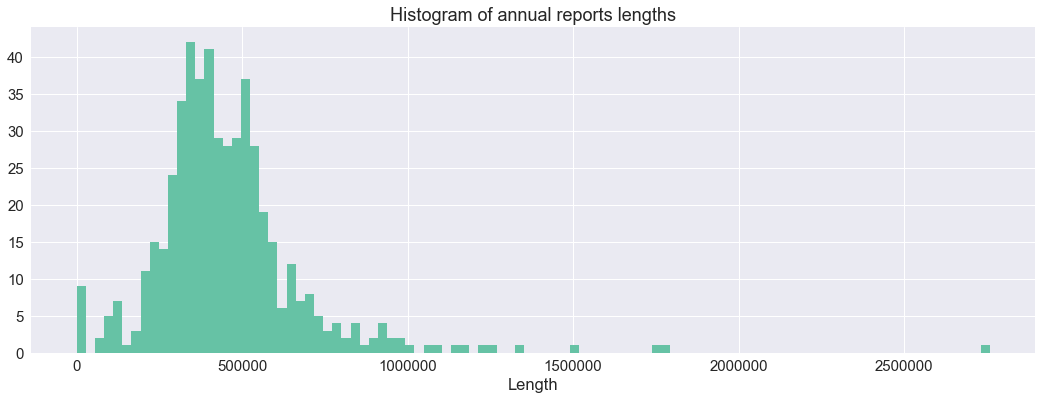

In [11]:
ax = df.Form10K.map(len).hist(figsize=(18, 6), bins=100)
ax.set_title("Histogram of annual reports lengths")
ax.set_xlabel("Length")

Let's the company with maximum annual report length and company with minimum annual report length.

Company with the maximum annual report length:

In [12]:
idx = df.Form10K.map(len).idxmax()
print("The character length of document: ", len(df.loc[idx].Form10K))
df.loc[idx:idx]

The character length of document:  2758887


,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Location,Date first added[3][4],CIK,Founded,File,Form10K,tokens
419,SO,Southern Co.,reports,Utilities,Electric Utilities,"Atlanta, Georgia",NaN,92122,NaN,SO/so_10-kx12312017.htm,10-K1so_10-kx12312017.htm10-KDocument Table...,"['10-k1so_10-kx12312017.htm10-kdocument', ' ..."


Company with the minimum annual report length:

In [13]:
idx = df.Form10K.map(len).idxmin()
print("The character length of document: ", len(df.loc[idx].Form10K))
df.loc[idx:idx]

The character length of document:  2


,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Location,Date first added[3][4],CIK,Founded,File,Form10K,tokens
57,AIZ,Assurant Inc.,reports,Financials,Multi-line Insurance,"New York, New York",4/10/07,1267238,NaN,AIZ/aiz1231201710k.htm,,[' ']


In [14]:
df[df.Form10K.map(len) < 100]

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Location,Date first added[3][4],CIK,Founded,File,Form10K,tokens
57,AIZ,Assurant Inc.,reports,Financials,Multi-line Insurance,"New York, New York",4/10/07,1267238,NaN,AIZ/aiz1231201710k.htm,,[' ']
59,ADSK,Autodesk Inc.,reports,Information Technology,Application Software,"San Rafael, California",12/1/89,769397,NaN,ADSK/adsk-0131201810xk.htm,,[' ']
139,CMI,Cummins Inc.,reports,Industrials,Industrial Machinery,"Columbus, Indiana",3/31/65,26172,1919,CMI/cmi2017final10-kdocume.htm,,[' ']
146,DAL,Delta Air Lines Inc.,reports,Industrials,Airlines,"Atlanta, Georgia",9/11/13,27904,NaN,DAL/dal1231201710k.htm,,[' ']
166,EBAY,eBay Inc.,reports,Information Technology,Internet Software & Services,"San Jose, California",NaN,1065088,1995,EBAY/ebay201710-k.htm,,[' ']
259,INTU,Intuit Inc.,reports,Information Technology,Internet Software & Services,"Mountain View, California",12/5/00,896878,NaN,INTU/fy17q410-kdocument.htm,,[' ']
308,MCD,McDonald's Corp.,reports,Consumer Discretionary,Restaurants,"Chicago, Illinois",6/30/70,63908,1940,MCD/mcd-12312017x10k.htm ./MCD/mcd1231201710k.pdf,,[' ']
499,XYL,Xylem Inc.,reports,Industrials,Industrial Machinery,"White Plains, New York",11/1/11,1524472,NaN,XYL/xyl1231201710k.htm,,[' ']
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",10/6/97,1041061,NaN,YUM/yum10k12312017.htm,,[' ']


## Text Preprocessing

### Tf-idf

In [109]:
vectorizer = TfidfVectorizer(max_df=0.95,
                             min_df=5,
                             analyzer='word',
                             ngram_range=(1, 2),
                             stop_words='english'
                            )
vectz = vectorizer.fit_transform(df['tokens'].values)
vectz.shape

(504, 299003)

In [110]:
# Create a dictionary mapping tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

#### Histogram of Tf-idf

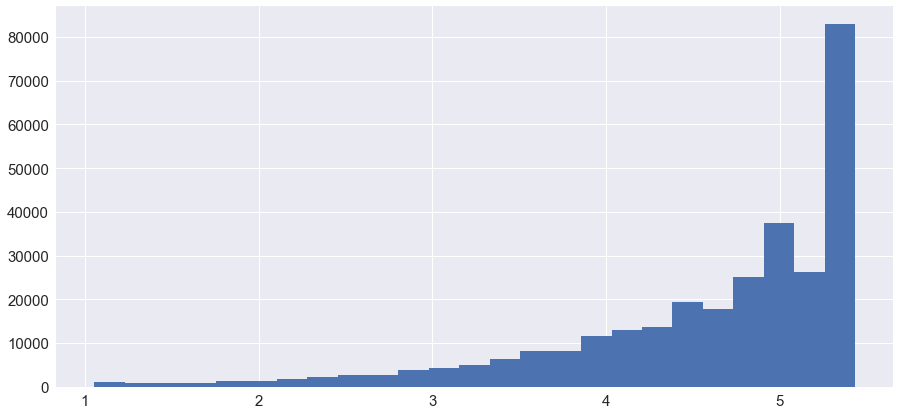

In [111]:
tfidf.tfidf.hist(bins=25, figsize=(15,7))

#### 50 words with lowest tfidf scores (more common words)

In [112]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    word_cloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

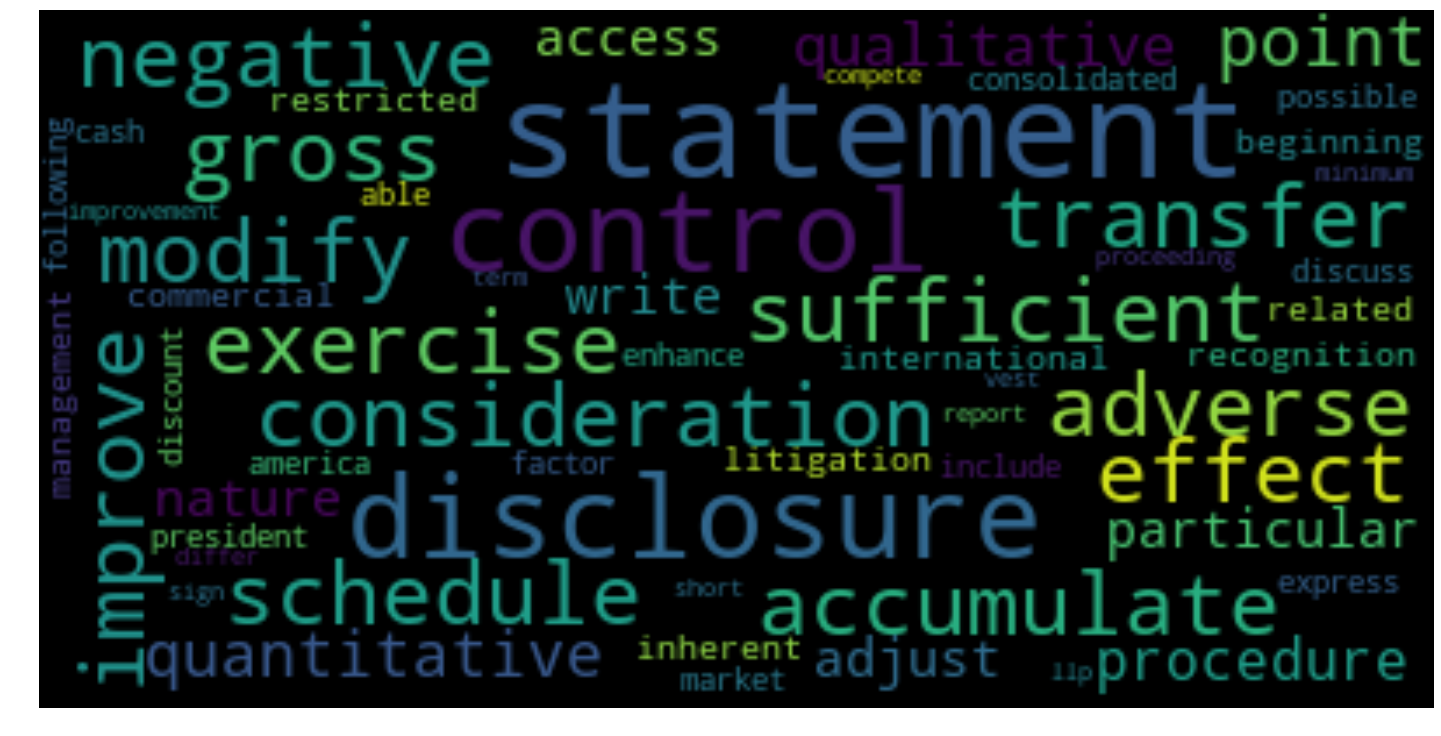

In [114]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(50))

#### 50 words with highest tfidf scores (less common words)

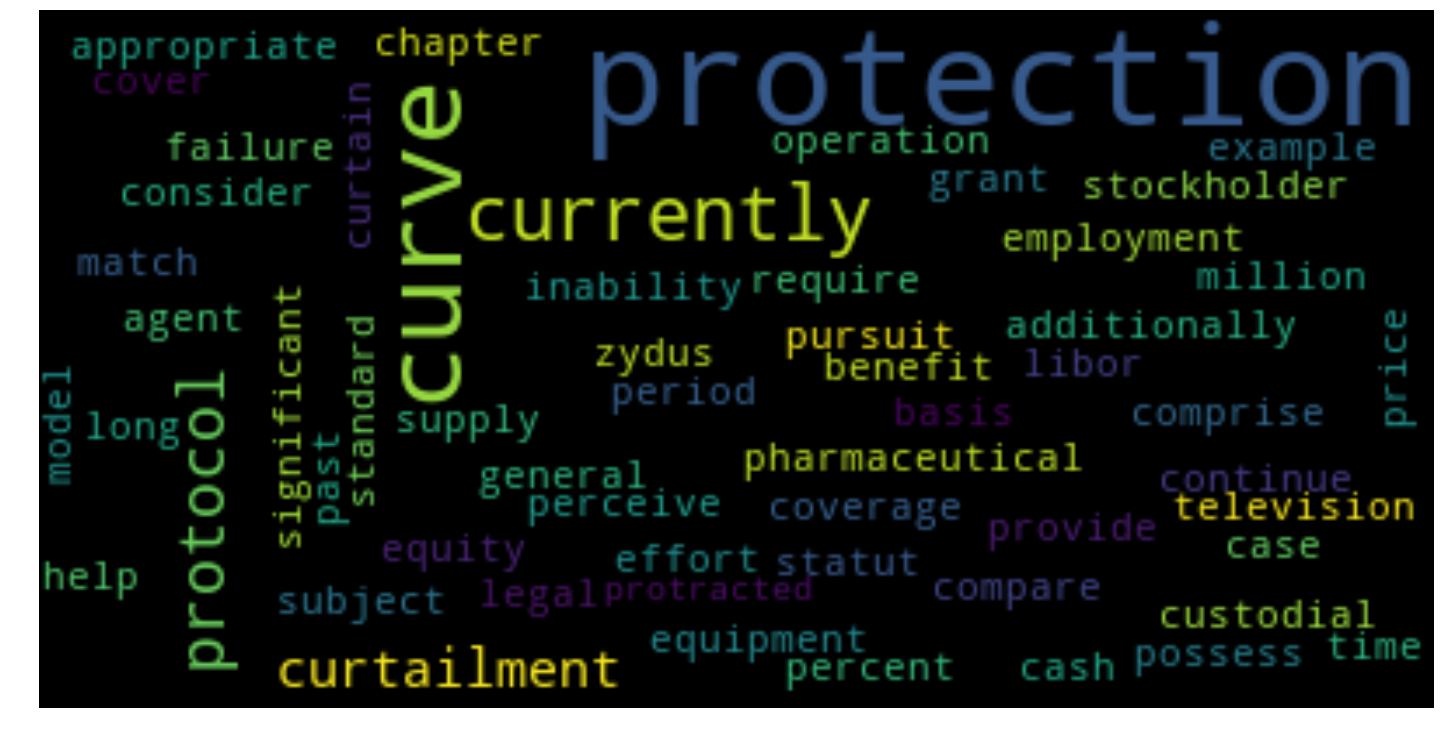

In [115]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(50))

### Plotting Tfidf on 2D

In [116]:
# Step 1: Reduce to 100 (using SVD)
svd = TruncatedSVD(n_components=100, random_state=0)
svd_tfidf = svd.fit_transform(vectz)
svd_tfidf.shape

(504, 100)

In [117]:
# Step 2: From 100 to 2 (usinf t-SNE)
run = True
if run:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['GICS Sector'] = df['GICS Sector']
    tsne_tfidf_df['Form10K'] = df['Form10K']
    tsne_tfidf_df['tokens'] = df['tokens']
    tsne_tfidf_df.to_csv("private/tsne_tfidf_sandp500.csv", encoding="utf-8", index=False)
else:
    tsne_tfidf_df = pd.read_csv("private/tsne_tfidf_sandp500.csv")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 504 samples in 0.002s...
[t-SNE] Computed neighbors for 504 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 504 / 504
[t-SNE] Mean sigma: 0.277579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.272285
[t-SNE] Error after 500 iterations: 0.829356
(504, 2)


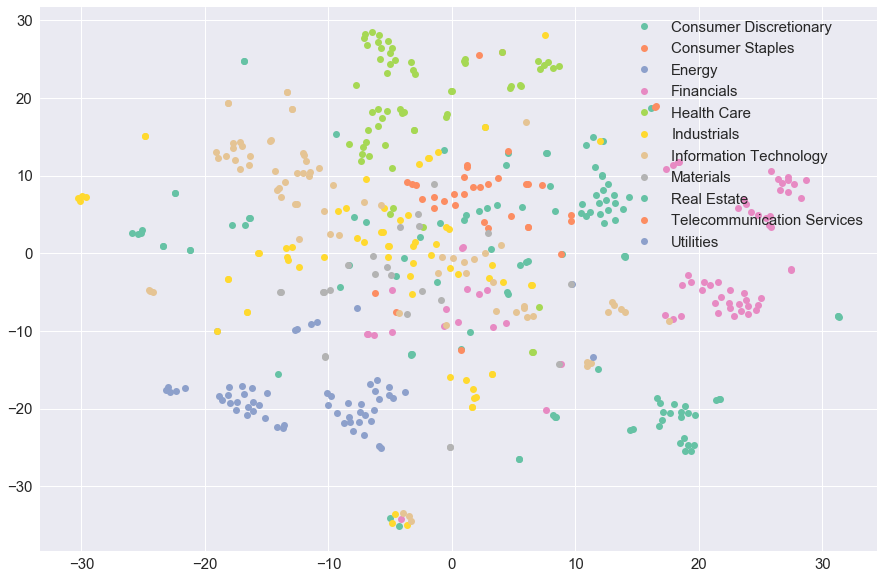

In [118]:
# Plot on a 2D
sectors = tsne_tfidf_df.groupby('GICS Sector')
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_prop_cycle('color', sns.color_palette("Set2", 11))
ax.margins(0.05)
for name, sector in sectors:
    ax.plot(sector.x, sector.y, marker='o', linestyle='', label=name)
ax.legend()
plt.show()

## Clustering

### KMeans

#### Choosing k

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

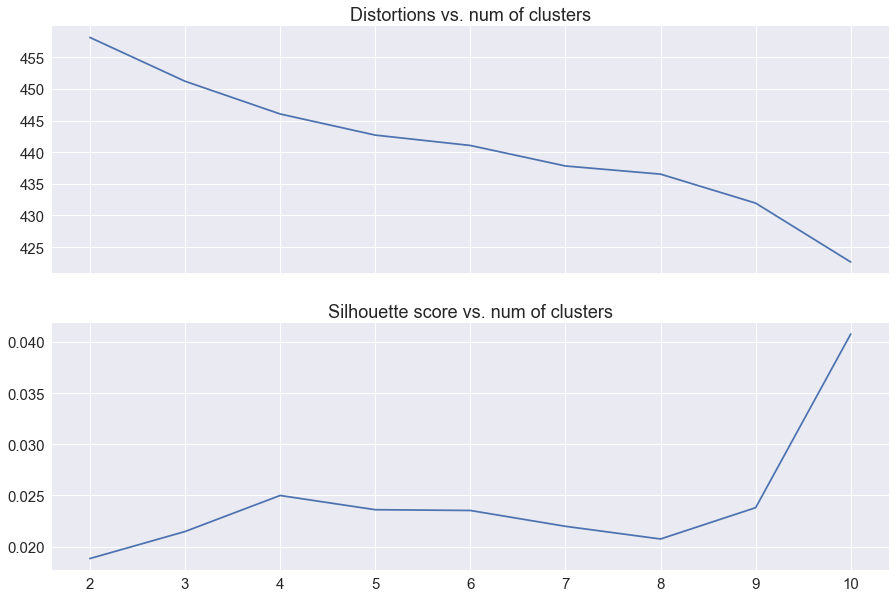

In [153]:
distortions = []
sil_scores = []
k_max = 11
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = KMeans(n_clusters=k, 
                          init='k-means++',
                          n_init=1, 
                          random_state=4222)
    kmeans_model.fit(vectz)
    sil_score = silhouette_score(vectz, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distortions.append(kmeans_model.inertia_)
 
# plot graphs to choose k
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distortions)
ax1.set_title('Distortions vs. num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs. num of clusters')
ax2.grid(True)

In [167]:
num_clusters = 4
kmeans_model = KMeans(n_clusters=num_clusters, 
                      init='k-means++',
                      n_init=1, 
                      random_state=4222)

kmeans = kmeans_model.fit(vectz)
kmeans_clusters = kmeans.predict(vectz)
kmeans_distances = kmeans.transform(vectz)

In [168]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)],
                           columns=['keywords_{0}'.format(i) for i in range(10)],
                           data=all_keywords)

### Plot KMeans

In [169]:
run = True
if run:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=4222, n_iter=500)
    tsne_kmeans = tsne_model.fit_transform(kmeans_distances)
    kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
    kmeans_df['cluster'] = kmeans_clusters
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)
    kmeans_df['GICS Sector'] = df['GICS Sector']
    kmeans_df['GICS Sub Industry'] = df['GICS Sub Industry']
    kmeans_df['Company'] = df['Security']
    kmeans_df['keywords'] = kmeans_df['cluster'].apply(lambda x: ", ".join(list(keywords_df.loc['topic_{}'.format(x)])))
    kmeans_df.to_csv("private/sandp_tsne_kmeans.csv", index=False, encoding="utf-8")
else:
    kmeans_df = pd.read_csv("private/sandp_tsne_kmeans.csv")
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 504 samples in 0.000s...
[t-SNE] Computed neighbors for 504 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 504 / 504
[t-SNE] Mean sigma: 0.010750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.733997
[t-SNE] Error after 500 iterations: 0.404649


In [170]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690"])

reset_output()
output_notebook()
plot_kmeans = bp.figure(plot_width=900, plot_height=600, title="KMeans clustering",
                        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                        x_axis_type=None, y_axis_type=None, min_border=1)

source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    sector=kmeans_df['GICS Sector'],
                                    subsector=kmeans_df['GICS Sub Industry'],
                                    company=kmeans_df['Company'],
                                    keywords=kmeans_df['keywords'],
                                    cluster=kmeans_df['cluster'],
                                    label=kmeans_df['GICS Sector'])
                         )

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"GICS Sector": "@sector", "GICS Sub Industry":"@subsector", 
                "Company":"@company", "cluster":"@cluster", "keywords":"@keywords" }
show(plot_kmeans)

Loading BokehJS ...

In [171]:
keywords_df

,keywords_0,keywords_1,keywords_2,keywords_3,keywords_4,keywords_5,keywords_6,keywords_7,keywords_8,keywords_9
topic_0,gas,natural gas,oil,energy,electric,natural,crude,crude oil,pipeline,production
topic_1,loan,tag,fair value,mortgage,reinsurance,derivative,tag fact,end december,filter,billion
topic_2,fair value,foreign,end december,currency,million million,billion,impairment,respectively,pension,goodwill
topic_3,tenant,reit,real estate,estate,real,realty,partnership,end december,operate partnership,apartment


In [172]:
df[df['Security']=='Consolidated Edison']

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Location,Date first added,CIK,Founded,File,Form10K,tokens
130,ED,Consolidated Edison,Utilities,Electric Utilities,"New York, New York",NaN,1047862,1823,ED/ed-20171231x10k.htm,10-K 1 ed-20171231x10k.htm 10-K Document UNITE...,htm document unite statessecuritie and exchang...
